In [51]:
!pip install "numpy<2.3.0" --force-reinstall
!pip install -U pillow matplotlib
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers datasets evaluate accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 30.8 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
    Uninstalling numpy-2.3.4:
      Successfully uninstalled numpy-2.3.4
Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
!pip install -U opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 1.3 MB/s  0:00:51m0:00:0100:020m


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
!pip install PyDrive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 957.7 kB/s  0:00:01a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 1.6 MB/s  0:00:08m0:00:0100:01
  Created wheel for PyDrive: filename=pydrive-1.3.1-py3-none-any.whl size=27539 sha256=8beec5badf17400c89adad7fcb41565bd14c5cecdce17bbee715d9c0ae52dc7b
  Stored in directory: /workspace/.cache/pip/wheels/6c/10/da/a5b513f5b3916fc391c20ee7b4633e5cf3396d570cdd74970f
Successfully built PyDrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [PyDrive]3/14 [PyDrive]pi-python-client]


In [4]:
!pip install --upgrade gdown

import gdown
import os

# File ID ของไฟล์ zip
file_id = "1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR"
zip_path = "./unet_dataset.zip"

# ดาวน์โหลดไฟล์ zip
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

# แตกไฟล์ zip
import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("./unet_dataset")

print("Download and unzip completed! Files are in ./unet_dataset")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gdown]


Downloading...
From (original): https://drive.google.com/uc?id=1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR
From (redirected): https://drive.google.com/uc?id=1ndCj8rEXuaQkMhfJWBclEeZAp3cbNwzR&confirm=t&uuid=adaf5874-af2b-406f-9c09-e102f30600aa
To: /workspace/unet_dataset.zip
100%|██████████| 2.13G/2.13G [02:38<00:00, 13.5MB/s]


Download and unzip completed! Files are in ./unet_dataset


In [5]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 5.9 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 21.0 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [56]:
import transformers, datasets, evaluate, accelerate
import os

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("evaluate:", evaluate.__version__)
print("accelerate:", accelerate.__version__)

transformers: 4.57.1
datasets: 4.3.0
evaluate: 0.4.6
accelerate: 1.11.0


In [4]:
# ---------------- Cell 1: paths & pairs ----------------
import os, json
from glob import glob
from PIL import Image
import numpy as np

# ตั้งพาธหลักให้ถูกกับเครื่องคุณ
ROOT = "/workspace/unet_dataset/crack_segmentation_dataset"
OUTPUT_DIR = os.path.join(ROOT, "output_segformer")
os.makedirs(OUTPUT_DIR, exist_ok=True)

TRAIN_IMG_DIR  = os.path.join(ROOT, "train", "images")
TRAIN_MASK_DIR = os.path.join(ROOT, "train", "masks")
TEST_IMG_DIR   = os.path.join(ROOT, "test",  "images")
TEST_MASK_DIR  = os.path.join(ROOT, "test",  "masks")

def list_images(folder):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts:
        files += glob(os.path.join(folder, e))
    return sorted(files)

def normalize_stem(p):
    n = os.path.splitext(os.path.basename(p))[0].lower()
    for suf in ["_mask","-mask",".mask","_gt","-gt","_label","-label","_seg","-seg","_m","-m"]:
        if n.endswith(suf):
            return n[: -len(suf)]
    return n

def build_pairs(img_dir, mask_dir):
    imgs = list_images(img_dir)
    msks = list_images(mask_dir)
    img_map = {normalize_stem(p): p for p in imgs}
    msk_map = {}
    for mp in msks:
        k = normalize_stem(mp)
        if k in msk_map and msk_map[k].lower().endswith(".jpg") and mp.lower().endswith(".png"):
            msk_map[k] = mp
        else:
            msk_map.setdefault(k, mp)
    pairs = []
    for k, ip in img_map.items():
        mp = msk_map.get(k, "")
        pairs.append((ip, mp if mp and os.path.isfile(mp) else ""))
    return pairs

train_pairs = build_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
test_pairs  = build_pairs(TEST_IMG_DIR,  TEST_MASK_DIR)
print(f"train pairs: {len(train_pairs)} | test pairs: {len(test_pairs)}")


train pairs: 9603 | test pairs: 1695


In [5]:
NUM_LABELS   = 2
IGNORE_INDEX = 255
id2label = {0: "background", 1: "defect"}
label2id = {"background": 0, "defect": 1}

# --------- remark --------------
def remap_mask_to_contiguous(arr: np.ndarray) -> np.ndarray:
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    lut = np.full(256, IGNORE_INDEX, dtype=np.uint8)
    lut[0]   = 0
    lut[255] = 1
    return lut[arr].astype(np.int64)


In [6]:
m = np.array(Image.open(train_pairs[0][1]).convert("L"))
mapped = remap_mask_to_contiguous(m)
print(np.unique(mapped))


[  0   1 255]


In [24]:
# ---------------- Cell 3: config ----------------
from dataclasses import dataclass

@dataclass
class CFG:
    root: str = ROOT
    output_dir: str = OUTPUT_DIR
    model_name: str = "nvidia/segformer-b1-finetuned-ade-512-512"
    img_size: int = 512
    batch_size: int = 20
    epochs: int = 25
    lr: float = 5e-5
    weight_decay: float = 1e-4
    seed: int = 42
    ignore_index: int = IGNORE_INDEX

cfg = CFG()
cfg


CFG(root='/workspace/unet_dataset/crack_segmentation_dataset', output_dir='/workspace/unet_dataset/crack_segmentation_dataset/output_segformer', model_name='nvidia/segformer-b1-finetuned-ade-512-512', img_size=512, batch_size=20, epochs=25, lr=5e-05, weight_decay=0.0001, seed=42, ignore_index=255)

In [9]:
# ---------------- Cell 4: processor & model ----------------
import torch
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
processor = AutoImageProcessor.from_pretrained(cfg.model_name)

model = SegformerForSemanticSegmentation.from_pretrained(
    cfg.model_name,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(device)
model.eval(); print("Loaded:", cfg.model_name, "| device:", device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in t

Loaded: nvidia/segformer-b1-finetuned-ade-512-512 | device: cuda


In [10]:
# ---------------- Cell 5: datasets ----------------
from datasets import Dataset, DatasetDict

def to_dataset(pairs):
    return Dataset.from_dict({"image_path":[ip for ip,_ in pairs],
                              "mask_path":[mp for _,mp in pairs]})

ds = DatasetDict({"train": to_dataset(train_pairs),
                  "test":  to_dataset(test_pairs)})

def _load_example(example):
    ip, mp = example["image_path"], example["mask_path"]
    img = Image.open(ip).convert("RGB")
    # เตรียม mask
    if mp and os.path.isfile(mp):
        m = Image.open(mp).convert("L").resize((cfg.img_size, cfg.img_size), Image.NEAREST)
        m = remap_mask_to_contiguous(np.array(m))
    else:
        m = np.zeros((cfg.img_size, cfg.img_size), dtype=np.int64)
    enc = processor(images=img, segmentation_maps=[m], return_tensors="pt")
    return {"pixel_values": enc["pixel_values"][0],
            "labels": enc["labels"][0].long()}

ds = ds.map(_load_example, remove_columns=["image_path","mask_path"])
ds.set_format(type="torch", columns=["pixel_values","labels"])

# def preprocess(example):
#     img = Image.open(example["image_path"]).convert("RGB")
#     mask = Image.open(example["mask_path"]).convert("L").resize((cfg.img_size,cfg.img_size), Image.NEAREST)
#     mask = remap_mask_to_contiguous(np.array(mask))
#     enc = processor(images=img, segmentation_maps=[mask], return_tensors="pt")
#     return {"pixel_values": enc["pixel_values"][0], "labels": enc["labels"][0].long()}

# ds = ds.map(preprocess)

print(ds)


Map:   0%|          | 0/9603 [00:00<?, ? examples/s]

Map:   0%|          | 0/1695 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 9603
    })
    test: Dataset({
        features: ['pixel_values', 'labels'],
        num_rows: 1695
    })
})


In [17]:
# ---------------- Cell 6: metrics ----------------
import numpy as np
from PIL import Image

def iou_score(pred, target, num_classes, ignore_index=255):
    mask = np.ones_like(target, dtype=bool)
    if ignore_index is not None:
        mask &= (target != ignore_index)
    ious = []
    for c in range(num_classes):
        p = (pred == c) & mask
        t = (target == c) & mask
        inter = np.logical_and(p, t).sum()
        union = np.logical_or(p, t).sum()
        ious.append(inter/union if union else 0.0)
    return np.array(ious), float(np.mean(ious)) if ious else 0.0

def compute_metrics(eval_preds):
    logits, labels = (eval_preds if isinstance(eval_preds, tuple)
                      else (eval_preds.predictions, eval_preds.label_ids))
    preds = logits.argmax(1)
    bs = preds.shape[0]; miou_list = []
    for i in range(bs):
        p = preds[i].astype(np.int32)
        y = labels[i].astype(np.int32)
        # ขนาดไม่เท่า ปรับด้วย PIL แบบ NEAREST
        if y.shape != p.shape:
            y = np.array(Image.fromarray(y).resize((p.shape[1], p.shape[0]), Image.NEAREST))
        _, miou = iou_score(p, y, NUM_LABELS, ignore_index=cfg.ignore_index)
        miou_list.append(miou)
    return {"mean_iou": float(np.mean(miou_list))}



In [18]:
import inspect
from transformers import TrainingArguments
print(inspect.signature(TrainingArguments.__init__))


(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: float = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str] = <factory>, warmup_ratio: float = 0.0, warmup_steps: int = 

In [20]:
from transformers import TrainingArguments
from transformers.trainer_utils import IntervalStrategy
import torch

args = TrainingArguments(
    output_dir=cfg.output_dir,
    per_device_train_batch_size=cfg.batch_size,
    per_device_eval_batch_size=cfg.batch_size,
    learning_rate=cfg.lr,
    num_train_epochs=cfg.epochs,
    weight_decay=cfg.weight_decay,

    # สำคัญ: เวอร์ชันของคุณใช้ 'eval_strategy'
    eval_strategy=IntervalStrategy.EPOCH,  # หรือ eval_strategy="epoch"

    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    save_total_limit=2,
    report_to=[],
    push_to_hub=False,
    remove_unused_columns=False,
    dataloader_num_workers=2,
    fp16=torch.cuda.is_available(),
    seed=cfg.seed,

    load_best_model_at_end=True,
    metric_for_best_model="eval_mean_iou",
    greater_is_better=True,
)


In [25]:
# ---------------- Cell 7: training ----------------
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback
import numpy as np

class LogTrainMetricsEachEpoch(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # วัดบนชุด train หลังจบ epoch
        metrics_train = trainer.evaluate(
            eval_dataset=trainer.train_dataset,
            metric_key_prefix="train"  # ทำให้มัน log เป็น train_mean_iou, train_loss
        )
        payload = {"epoch": float(state.epoch) if state.epoch is not None else np.nan}
        payload.update(metrics_train)
        trainer.log(payload)

trainer.add_callback(LogTrainMetricsEachEpoch())

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    processing_class=processor,    # ← แทน tokenizer=
    compute_metrics=compute_metrics,
   
)



trainer.train()
trainer.save_model(cfg.output_dir)
processor.save_pretrained(cfg.output_dir)
print(f"[OK] saved to {cfg.output_dir}")


Epoch,Training Loss,Validation Loss,Mean Iou
1,0.028900,0.034820,0.718192
2,0.032000,0.033782,0.727968
3,0.035200,0.033930,0.721015
4,0.029000,0.033171,0.729082
5,0.025700,0.033452,0.729252
6,0.028900,0.034248,0.723501
7,0.026100,0.034168,0.731861
8,0.025500,0.034473,0.727199
9,0.025900,0.034957,0.728891
10,0.024200,0.034618,0.728255


[OK] saved to /workspace/unet_dataset/crack_segmentation_dataset/output_segformer


In [26]:
# ---------------- Cell 8: inference & save ----------------
import matplotlib.pyplot as plt

SAVE_PRED_DIR    = os.path.join(cfg.output_dir, "pred_masks_test")
SAVE_OVERLAY_DIR = os.path.join(cfg.output_dir, "pred_overlays_test")
os.makedirs(SAVE_PRED_DIR, exist_ok=True)
os.makedirs(SAVE_OVERLAY_DIR, exist_ok=True)

def overlay_multi(img_pil, mask_ids, alpha=0.45):
    img = img_pil.convert("RGBA")
    h, w = mask_ids.shape
    K = int(mask_ids.max()) + 1
    cmap = plt.get_cmap("tab20")
    cols = (cmap(np.linspace(0,1,max(K,2)))[:, :3] * 255).astype(np.uint8)
    ov = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(1, K):
        m = (mask_ids == c)
        if m.any():
            ov[m,:3] = cols[c]; ov[m,3] = int(255*alpha)
    return Image.alpha_composite(img, Image.fromarray(ov))

@torch.no_grad()
def predict_pil(img_pil):
    x = processor(images=img_pil, return_tensors="pt").to(device)
    logits = model(**x).logits
    H, W = img_pil.size[1], img_pil.size[0]
    if logits.shape[-2:] != (H,W):
        logits = F.interpolate(logits, size=(H,W), mode="bilinear", align_corners=False)
    pred = logits.argmax(1)[0].cpu().numpy().astype(np.uint8)
    return pred

for ip, mp in test_pairs:
    img = Image.open(ip).convert("RGB")
    pred = predict_pil(img)

    base = os.path.splitext(os.path.basename(ip))[0]
    Image.fromarray(pred).save(os.path.join(SAVE_PRED_DIR, f"{base}_pred.png"))
    overlay_multi(img, pred).save(os.path.join(SAVE_OVERLAY_DIR, f"{base}_overlay.png"))

print("Pred masks   ->", SAVE_PRED_DIR)
print("Pred overlay ->", SAVE_OVERLAY_DIR)


Pred masks   -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
Pred overlay -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_overlays_test


In [27]:
# ---------------- Cell 9: per-image metrics & summary ----------------
import csv

def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

def metrics_from_cm(cm):
    tp = np.diag(cm); fp = cm.sum(0) - tp; fn = cm.sum(1) - tp
    with np.errstate(divide='ignore', invalid='ignore'):
        iou = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
    return {"mIoU": float(np.mean(iou)) if len(iou) else 0.0}

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
csv_path = os.path.join(cfg.output_dir, "metrics_test_per_image.csv")

with open(csv_path, "w", newline="") as f:
    w = csv.writer(f); w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in test_pairs:
        base = os.path.splitext(os.path.basename(ip))[0]
        pred = np.array(Image.open(os.path.join(SAVE_PRED_DIR, f"{base}_pred.png")))
        has_gt = bool(mp) and os.path.isfile(mp)
        if has_gt:
            gt_raw = np.array(Image.open(mp).convert("L").resize(pred.shape[::-1], Image.NEAREST))
            gt_ids = remap_mask_to_contiguous(gt_raw)
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            mIoU = metrics_from_cm(cm)["mIoU"]
            w.writerow([base, 1, int((gt_ids != IGNORE_INDEX).sum()), f"{mIoU:.4f}"])
        else:
            w.writerow([base, 0, 0, ""])

sum_csv = os.path.join(cfg.output_dir, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerows([["mIoU", f"{M['mIoU']:.6f}"]])
    print("Summary ->", sum_csv, "| mIoU =", f"{M['mIoU']:.4f}")
else:
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in test set"])
    print("No GT; wrote note to", sum_csv)


Summary -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_summary.csv | mIoU = 0.8007


PRED_DIR = /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
NUM_LABELS: 2 | model.num_labels: 2
CFD_002: classes=[0, 1] counts=[189582, 11122] pos=11122


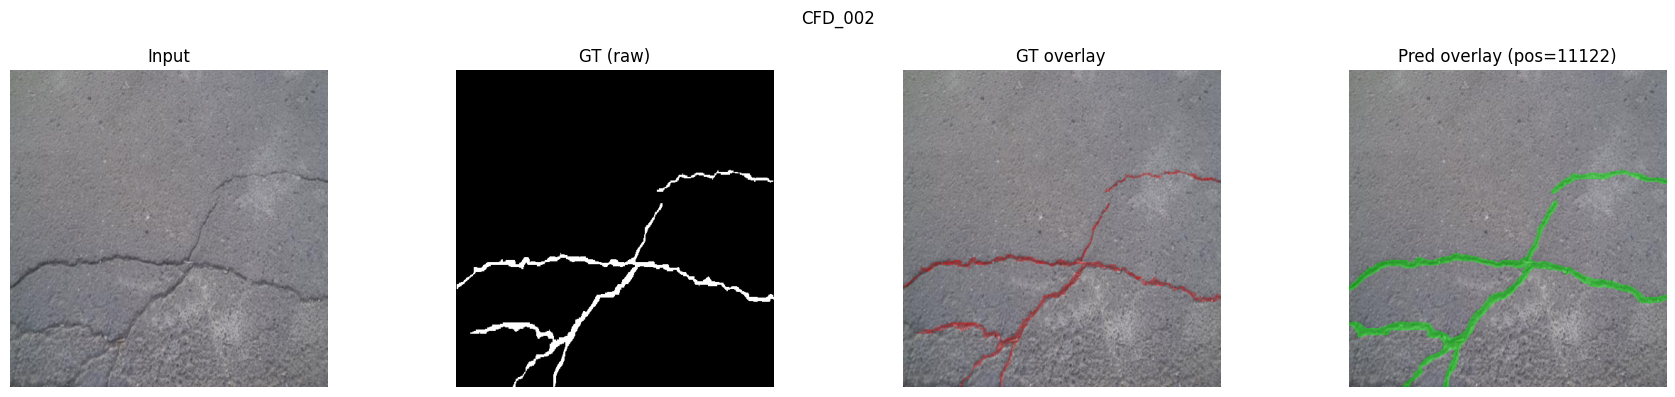

CFD_003: classes=[0, 1] counts=[194575, 6129] pos=6129


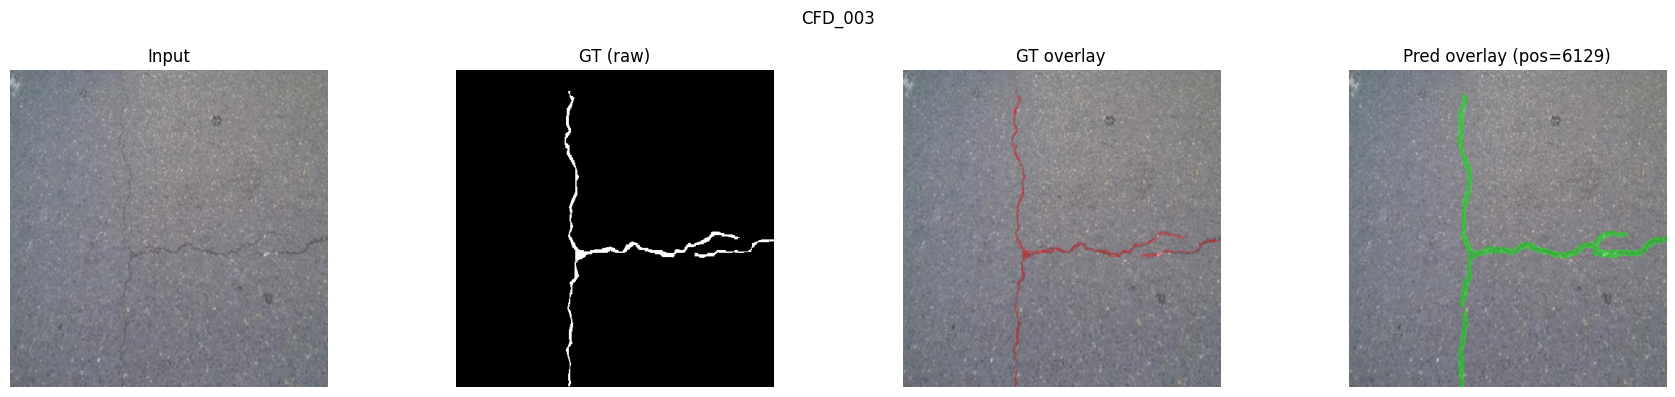

CFD_004: classes=[0, 1] counts=[195779, 4925] pos=4925


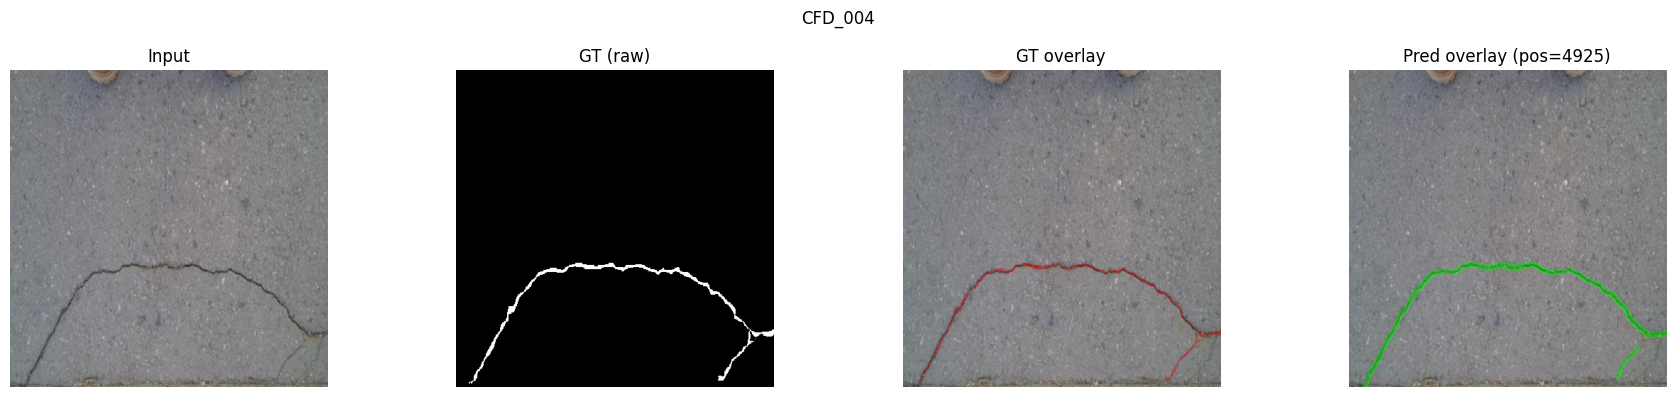

CFD_005: classes=[0, 1] counts=[196341, 4363] pos=4363


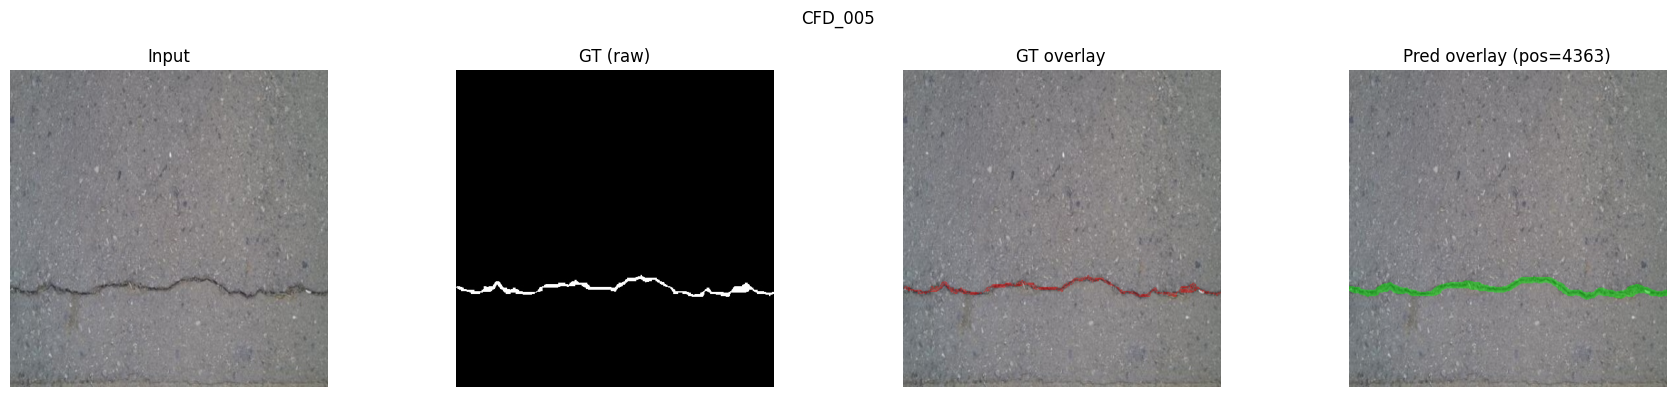

CFD_006: classes=[0, 1] counts=[197219, 3485] pos=3485


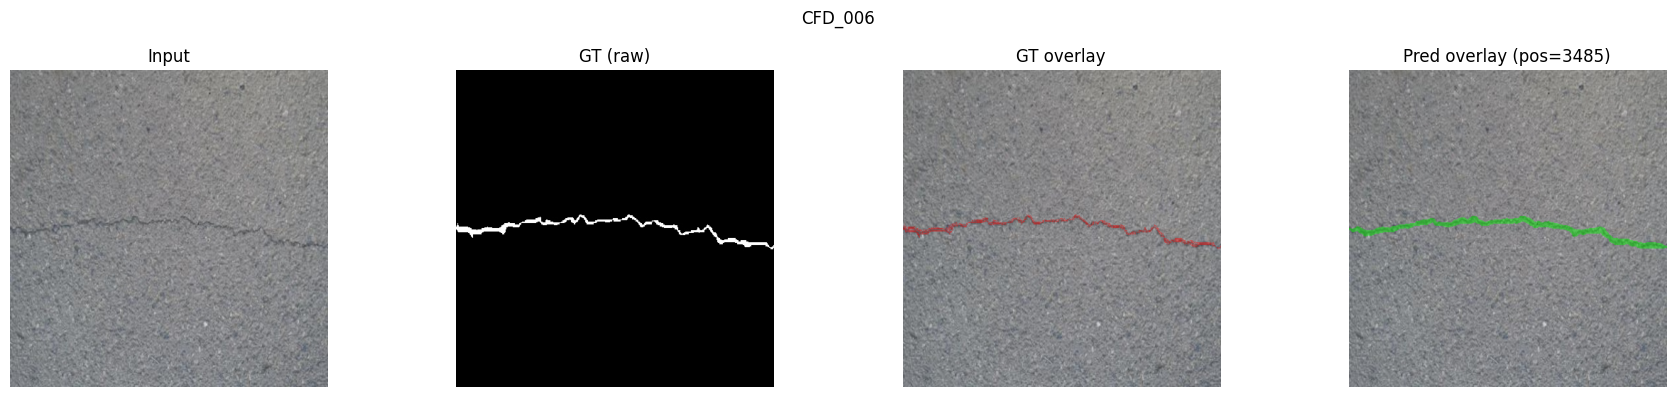

CFD_008: classes=[0, 1] counts=[195297, 5407] pos=5407


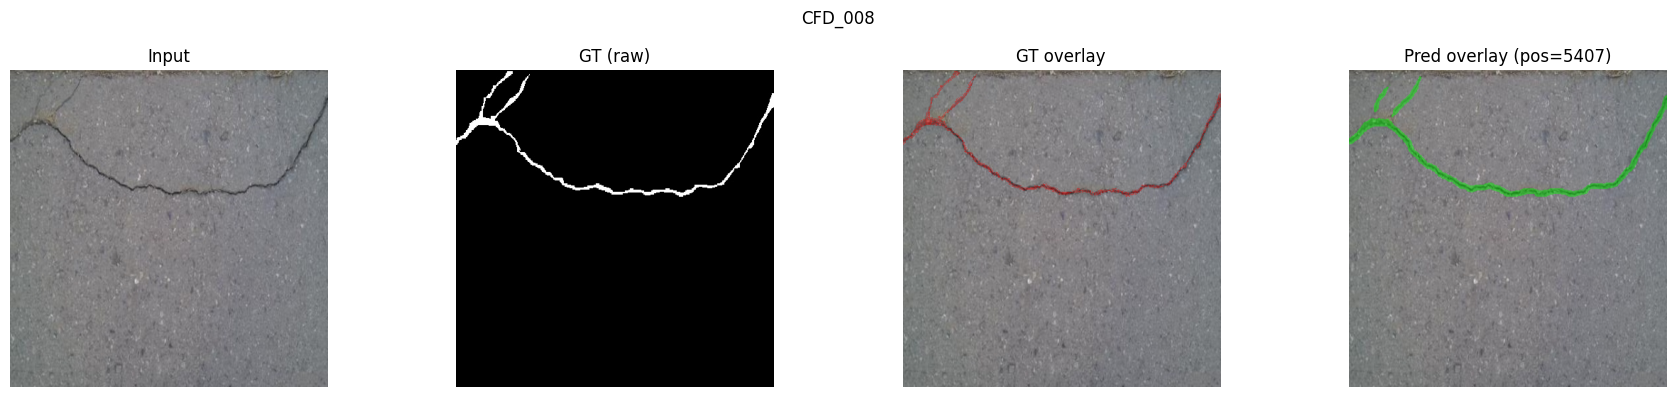

In [28]:

# ---------------- Cell 10.0 (patched, debug on) ----------------
import matplotlib.pyplot as plt

def overlay_binary(img_pil, mask_bool, color=(0,255,0), alpha=0.50):
    img = img_pil.convert("RGBA")
    h, w = mask_bool.shape
    ov = np.zeros((h,w,4), dtype=np.uint8)
    ov[mask_bool,:3] = color; ov[mask_bool,3] = int(255*alpha)
    return Image.alpha_composite(img, Image.fromarray(ov))

# ถ้าเคยใช้ชื่อโฟลเดอร์อื่น ให้ตั้งตรงนี้ให้ถูก
PRED_DIR = SAVE_PRED_DIR  # หรือ TEST_PRED_DIR ถ้าคุณเซฟไว้ชื่อนั้น
print("PRED_DIR =", PRED_DIR)
print("NUM_LABELS:", NUM_LABELS, "| model.num_labels:", getattr(model.config, "num_labels", None))

SAMPLES_TO_SHOW = 6
for ip, mp in train_pairs[:SAMPLES_TO_SHOW]:
    img  = Image.open(ip).convert("RGB")
    base = os.path.splitext(os.path.basename(ip))[0]
    pred_path = os.path.join(PRED_DIR, f"{base}_pred.png")

    # 1) โหลดจากไฟล์ ถ้าไม่มีให้ predict สด
    if os.path.isfile(pred_path):
        pred_ids = np.array(Image.open(pred_path))
    else:
        pred_ids = predict_pil(img)

    # 2) resize ให้เท่าภาพ
    if pred_ids.shape[::-1] != img.size:
        pred_ids = np.array(Image.fromarray(pred_ids).resize(img.size, Image.NEAREST))

    # 3) DEBUG: ดูคลาสที่ได้จริง
    uniq, cnt = np.unique(pred_ids, return_counts=True)
    print(f"{base}: classes={uniq.tolist()} counts={cnt.tolist()} pos={(pred_ids>0).sum()}")

    # 4) เตรียม GT
    has_gt = bool(mp) and os.path.isfile(mp)
    if has_gt:
        gt_raw_img = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
        gt_ids = remap_mask_to_contiguous(np.array(gt_raw_img))
        gt_bin = (gt_ids == 1) if NUM_LABELS >= 2 else (gt_ids > 0)
        gt_overlay = overlay_binary(img, gt_bin, color=(255,0,0), alpha=0.45)
    else:
        gt_raw_img = None; gt_overlay = None

    # 5) วาด Pred แบบไม่ยึดติดว่าต้องเป็นคลาส 1 เสมอ
    #    ถ้าคุณแน่ใจว่า defect=1 ก็ใช้ (pred_ids==1) ได้
    pred_bin_any = (pred_ids > 0)
    pred_overlay = overlay_binary(img, pred_bin_any, color=(0,255,0), alpha=0.45)

    # 6) plot
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1,4,2)
    if gt_raw_img is not None: plt.imshow(gt_raw_img, cmap="gray"); plt.title("GT (raw)")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT: None")
    plt.axis("off")
    plt.subplot(1,4,3)
    if gt_overlay is not None: plt.imshow(gt_overlay); plt.title("GT overlay")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT overlay: None")
    plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(pred_overlay); plt.title(f"Pred overlay (pos={(pred_ids>0).sum()})"); plt.axis("off")
    plt.suptitle(base); plt.tight_layout(); plt.show()


PRED_DIR = /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
NUM_LABELS: 2 | model.num_labels: 2
CFD_001: classes=[0, 1] counts=[195582, 5122] pos=5122


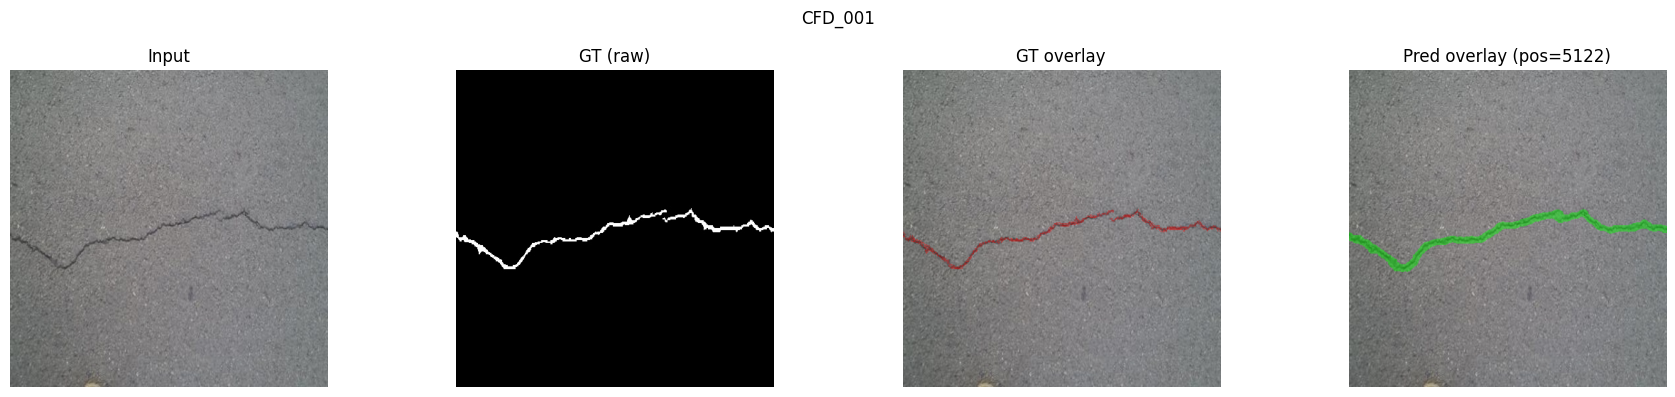

CFD_007: classes=[0, 1] counts=[196319, 4385] pos=4385


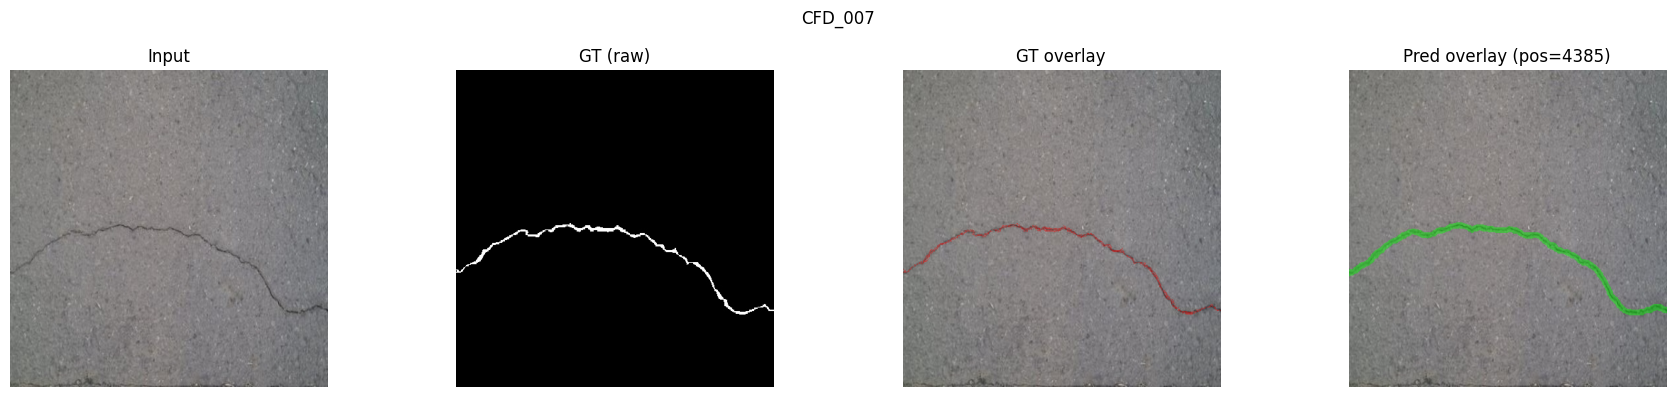

CFD_011: classes=[0, 1] counts=[196323, 4381] pos=4381


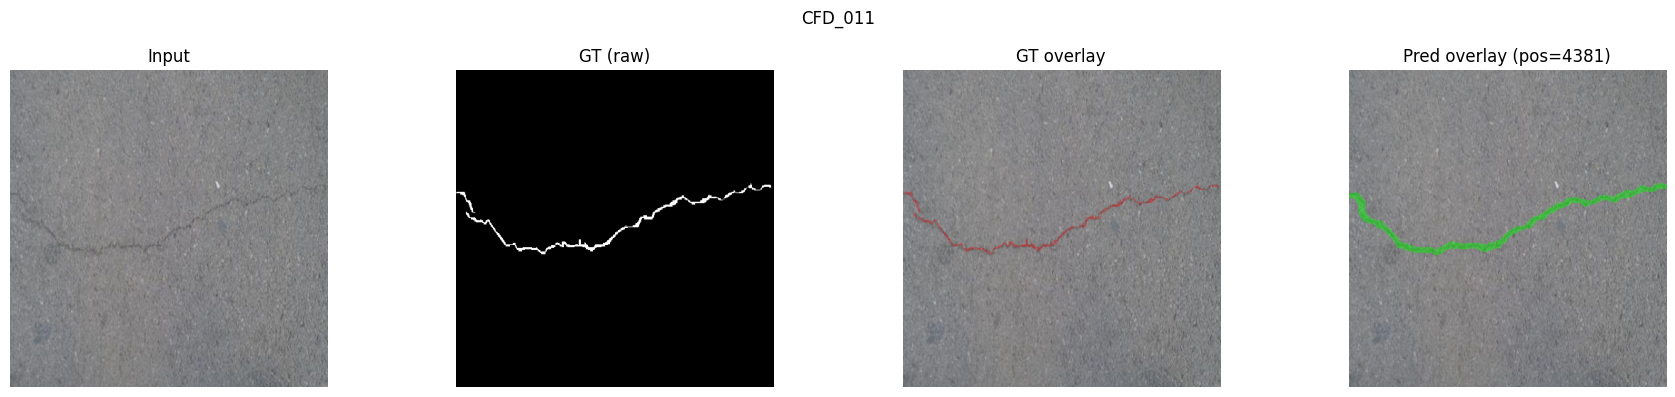

CFD_013: classes=[0, 1] counts=[189255, 11449] pos=11449


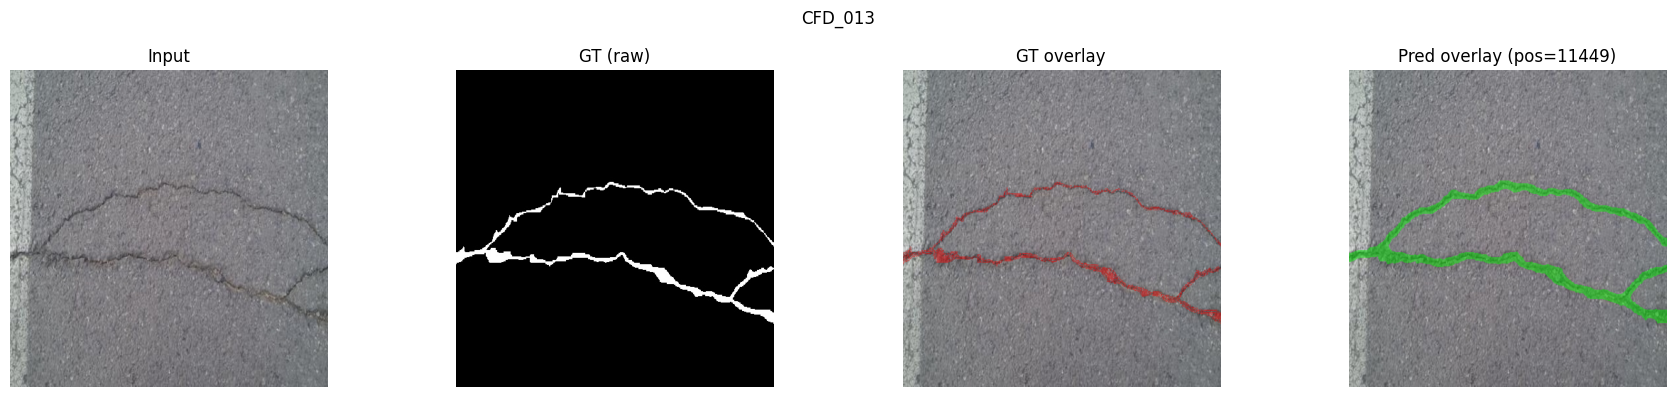

CFD_014: classes=[0, 1] counts=[197057, 3647] pos=3647


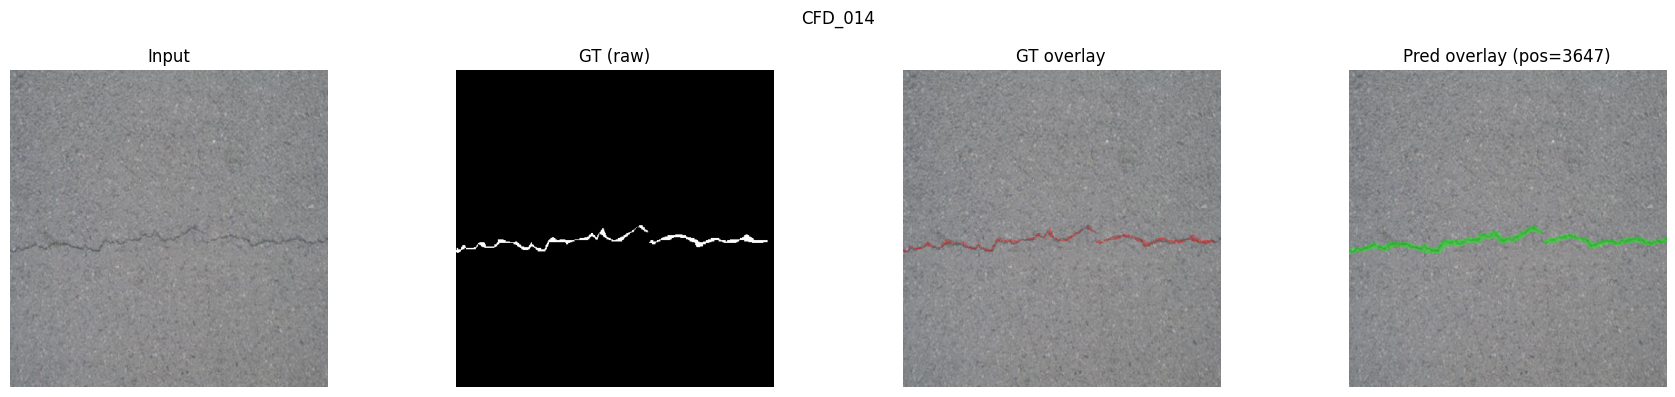

CFD_019: classes=[0, 1] counts=[192118, 8586] pos=8586


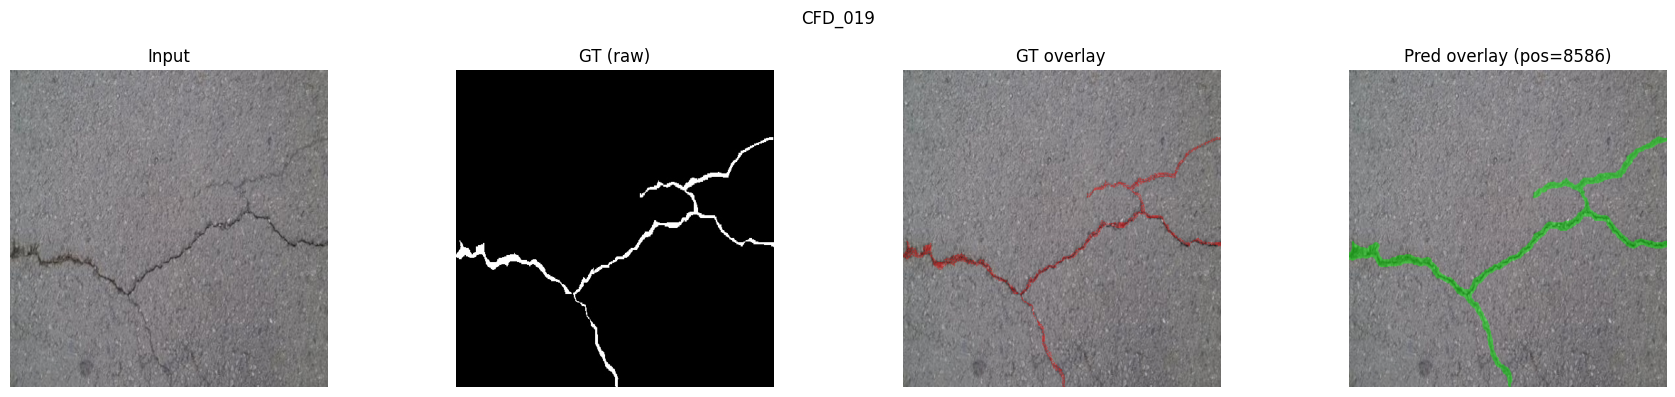

In [29]:
# ---------------- Cell 10.1 (patched, debug on) ----------------
import matplotlib.pyplot as plt

def overlay_binary(img_pil, mask_bool, color=(0,255,0), alpha=0.50):
    img = img_pil.convert("RGBA")
    h, w = mask_bool.shape
    ov = np.zeros((h,w,4), dtype=np.uint8)
    ov[mask_bool,:3] = color; ov[mask_bool,3] = int(255*alpha)
    return Image.alpha_composite(img, Image.fromarray(ov))

# ถ้าเคยใช้ชื่อโฟลเดอร์อื่น ให้ตั้งตรงนี้ให้ถูก
PRED_DIR = SAVE_PRED_DIR  # หรือ TEST_PRED_DIR ถ้าคุณเซฟไว้ชื่อนั้น
print("PRED_DIR =", PRED_DIR)
print("NUM_LABELS:", NUM_LABELS, "| model.num_labels:", getattr(model.config, "num_labels", None))

SAMPLES_TO_SHOW = 6
for ip, mp in test_pairs[:SAMPLES_TO_SHOW]:
    img  = Image.open(ip).convert("RGB")
    base = os.path.splitext(os.path.basename(ip))[0]
    pred_path = os.path.join(PRED_DIR, f"{base}_pred.png")

    # 1) โหลดจากไฟล์ ถ้าไม่มีให้ predict สด
    if os.path.isfile(pred_path):
        pred_ids = np.array(Image.open(pred_path))
    else:
        pred_ids = predict_pil(img)

    # 2) resize ให้เท่าภาพ
    if pred_ids.shape[::-1] != img.size:
        pred_ids = np.array(Image.fromarray(pred_ids).resize(img.size, Image.NEAREST))

    # 3) DEBUG: ดูคลาสที่ได้จริง
    uniq, cnt = np.unique(pred_ids, return_counts=True)
    print(f"{base}: classes={uniq.tolist()} counts={cnt.tolist()} pos={(pred_ids>0).sum()}")

    # 4) เตรียม GT
    has_gt = bool(mp) and os.path.isfile(mp)
    if has_gt:
        gt_raw_img = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
        gt_ids = remap_mask_to_contiguous(np.array(gt_raw_img))
        gt_bin = (gt_ids == 1) if NUM_LABELS >= 2 else (gt_ids > 0)
        gt_overlay = overlay_binary(img, gt_bin, color=(255,0,0), alpha=0.45)
    else:
        gt_raw_img = None; gt_overlay = None

    # 5) วาด Pred แบบไม่ยึดติดว่าต้องเป็นคลาส 1 เสมอ
    #    ถ้าคุณแน่ใจว่า defect=1 ก็ใช้ (pred_ids==1) ได้
    pred_bin_any = (pred_ids > 0)
    pred_overlay = overlay_binary(img, pred_bin_any, color=(0,255,0), alpha=0.45)

    # 6) plot
    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1); plt.imshow(img); plt.title("Input"); plt.axis("off")
    plt.subplot(1,4,2)
    if gt_raw_img is not None: plt.imshow(gt_raw_img, cmap="gray"); plt.title("GT (raw)")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT: None")
    plt.axis("off")
    plt.subplot(1,4,3)
    if gt_overlay is not None: plt.imshow(gt_overlay); plt.title("GT overlay")
    else:                       plt.imshow(np.zeros((10,10)));       plt.title("GT overlay: None")
    plt.axis("off")
    plt.subplot(1,4,4); plt.imshow(pred_overlay); plt.title(f"Pred overlay (pos={(pred_ids>0).sum()})"); plt.axis("off")
    plt.suptitle(base); plt.tight_layout(); plt.show()


In [30]:
import numpy as np
import pandas as pd

def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

def metrics_from_cm(cm):
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
        iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
        acc_cls   = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)

    # ไม่ตัดทศนิยมใดๆ ทั้งสิ้น (ให้เป็น float เต็มๆ)
    macro = {
        "mPrecision": float(np.mean(precision)) if len(precision) else 0.0,
        "mRecall":    float(np.mean(recall))    if len(recall)    else 0.0,
        "mF1":        float(np.mean(f1))        if len(f1)        else 0.0,
        "mIoU":       float(np.mean(iou))       if len(iou)       else 0.0,
        "mAcc":       float(np.mean(acc_cls))   if len(acc_cls)   else 0.0,
    }
    overall_acc = float(tp.sum() / cm.sum()) if cm.sum()>0 else 0.0

    return {
        "per_class": {"precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc_cls},
        "summary":   {**macro, "overall_acc": overall_acc}
    }

# ---------- สร้าง "ตาราง" แล้วพิมพ์ทศนิยมแบบเต็ม ----------
def metrics_table(cm, class_names=None, precision_digits=17):
    res = metrics_from_cm(cm)
    per = res["per_class"]
    df = pd.DataFrame({
        "precision": per["precision"],
        "recall":    per["recall"],
        "f1":        per["f1"],
        "iou":       per["iou"],
        "acc":       per["acc"],
    })
    if class_names:
        df.index = class_names

    # แปลงเป็น string ด้วย precision สูงสุดที่ยังมีสาระ (~16–17 digit)
    fmt = lambda x: np.format_float_positional(float(x), precision=precision_digits, unique=False, trim='k')
    df_str = df.applymap(fmt)

    summ = pd.DataFrame([res["summary"]])
    summ_str = summ.applymap(fmt)

    return df_str, summ_str

# ตัวอย่างใช้งาน:
# df_per_class, df_summary = metrics_table(cm, class_names=[f"class_{i}" for i in range(num_classes)])
# print(df_per_class.to_string())
# print(df_summary.to_string(index=False))


In [31]:
res = metrics_from_cm(cm)
print(res["per_class"]["precision"])   # numpy float array ดิบ
print(res["summary"])                  # dict of floats ดิบ

[1. 0.]
{'mPrecision': 0.5, 'mRecall': 0.5, 'mF1': 0.5, 'mIoU': 0.5, 'mAcc': 1.0, 'overall_acc': 1.0}


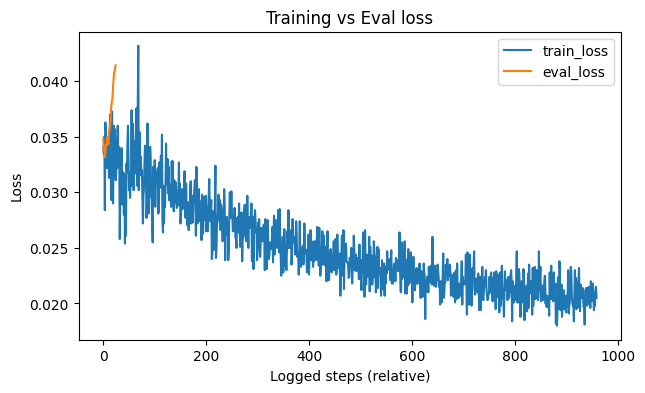

In [32]:
# ===== Plot training/eval losses to spot overfit visually =====
import matplotlib.pyplot as plt

logs = getattr(trainer.state, "log_history", [])
steps, train_loss, eval_loss = [], [], []

for rec in logs:
    if "loss" in rec and "epoch" in rec:  # training step
        steps.append(rec.get("step", len(steps)))
        train_loss.append(rec["loss"])
    if "eval_loss" in rec:
        # eval_loss จะมาจาก eval_dataset ของ Trainer (ของคุณ = ชุด test ที่เอามาเป็น val ชั่วคราว)
        eval_loss.append(rec["eval_loss"])

plt.figure(figsize=(7,4))
plt.plot(train_loss, label="train_loss")
if eval_loss:
    plt.plot(eval_loss, label="eval_loss")
plt.xlabel("Logged steps (relative)"); plt.ylabel("Loss"); plt.title("Training vs Eval loss")
plt.legend(); plt.show()


In [33]:
# ===== Cell B1: Evaluate TRAIN =====
import os, csv, numpy as np
from PIL import Image

# ---- Fallback helpers (ใช้ของเดิมถ้ามี) ----
if 'confusion_from_pair' not in globals():
    def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
        if ignore_index is not None:
            mask = (gt != ignore_index)
            gt = gt[mask]; pred = pred[mask]
        idx = gt * num_classes + pred
        return np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)

if 'metrics_from_cm' not in globals():
    def metrics_from_cm(cm):
        tp = np.diag(cm).astype(np.float64)
        fp = cm.sum(0) - tp
        fn = cm.sum(1) - tp
        tn = cm.sum() - (tp + fp + fn)
        with np.errstate(divide='ignore', invalid='ignore'):
            precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
            recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
            f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
            iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
            acc_cls   = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)
        macro = {
            "mPrecision": float(np.mean(precision)) if len(precision) else 0.0,
            "mRecall":    float(np.mean(recall))    if len(recall)    else 0.0,
            "mF1":        float(np.mean(f1))        if len(f1)        else 0.0,
            "mIoU":       float(np.mean(iou))       if len(iou)       else 0.0,
            "mAcc":       float(np.mean(acc_cls))   if len(acc_cls)   else 0.0,
        }
        overall_acc = float(tp.sum()/cm.sum()) if cm.sum()>0 else 0.0
        return {"per_class": {"precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc_cls},
                "summary":   {**macro, "overall_acc": overall_acc}}

OUT_DIR = cfg.output_dir
os.makedirs(OUT_DIR, exist_ok=True)

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
per_image_csv = os.path.join(OUT_DIR, "metrics_train_per_image.csv")

with open(per_image_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in train_pairs:
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)  # 0..K-1, เท่าขนาดภาพ

        if mp and os.path.isfile(mp):
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_ids = remap_mask_to_contiguous(np.array(gt_raw))
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)
            w.writerow([os.path.basename(ip), 1, int((gt_ids != IGNORE_INDEX).sum()), f"{m['summary']['mIoU']:.4f}"])
        else:
            w.writerow([os.path.basename(ip), 0, 0, ""])

summary_csv = os.path.join(OUT_DIR, "metrics_train_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(summary_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["metric","value"])
        for k,v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("[TRAIN] summary:", {k: f"{v:.4f}" for k,v in M["summary"].items()})
else:
    with open(summary_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in train set"])
    print("[TRAIN] No GT in train set")

# ---- Train-only risk hint (ยังไม่ตัดสิน overfit จริง) ----
def train_risk_hint(summary_path, high_bar=0.85):
    d = {}
    if os.path.isfile(summary_path):
        for row in csv.reader(open(summary_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    tr = d.get("mIoU", None)
    if tr is None: 
        print("[TRAIN] risk: insufficient data")
    elif tr >= high_bar:
        print(f"[TRAIN] risk: very high train mIoU={tr:.3f} (ตรวจ test ต่อเพื่อดู overfit)")
    else:
        print(f"[TRAIN] risk: train mIoU={tr:.3f} (ยังไม่ชี้ชัด ต้องเทียบกับ test)")

train_risk_hint(summary_csv)


[TRAIN] summary: {'mPrecision': '0.9318', 'mRecall': '0.9106', 'mF1': '0.9209', 'mIoU': '0.8624', 'mAcc': '0.9917', 'overall_acc': '0.9917'}
[TRAIN] risk: very high train mIoU=0.862 (ตรวจ test ต่อเพื่อดู overfit)


In [34]:
# ===== Cell B2: Evaluate TEST =====
import os, csv, numpy as np
from PIL import Image

# ใช้ helper จาก B1 ถ้ามีแล้ว

OUT_DIR = cfg.output_dir
os.makedirs(OUT_DIR, exist_ok=True)

cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
per_image_csv = os.path.join(OUT_DIR, "metrics_test_per_image.csv")

with open(per_image_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["image","has_gt","pixels_used","mIoU"])
    for ip, mp in test_pairs:
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)

        if mp and os.path.isfile(mp):
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_ids = remap_mask_to_contiguous(np.array(gt_raw))
            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)
            w.writerow([os.path.basename(ip), 1, int((gt_ids != IGNORE_INDEX).sum()), f"{m['summary']['mIoU']:.4f}"])
        else:
            w.writerow([os.path.basename(ip), 0, 0, ""])

summary_csv = os.path.join(OUT_DIR, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    with open(summary_csv, "w", newline="") as f:
        w = csv.writer(f); w.writerow(["metric","value"])
        for k,v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("[TEST] summary:", {k: f"{v:.4f}" for k,v in M["summary"].items()})
else:
    with open(summary_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note","No GT in test set"])
    print("[TEST] No GT in test set")

# ---- Test-only generalization hint ----
def test_hint(summary_path, ok_bar=0.70):
    d = {}
    if os.path.isfile(summary_path):
        for row in csv.reader(open(summary_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    te = d.get("mIoU", None)
    if te is None:
        print("[TEST] hint: insufficient data")
    elif te >= ok_bar:
        print(f"[TEST] hint: mIoU={te:.3f} (generalization พอใช้/ดี)")
    else:
        print(f"[TEST] hint: mIoU={te:.3f} (generalization อ่อน พิจารณาเพิ่ม data/aug/regularization)")

test_hint(summary_csv)


[TEST] summary: {'mPrecision': '0.8959', 'mRecall': '0.8604', 'mF1': '0.8773', 'mIoU': '0.8007', 'mAcc': '0.9873', 'overall_acc': '0.9873'}
[TEST] hint: mIoU=0.801 (generalization พอใช้/ดี)


In [35]:
# ===== Cell C: Compare TRAIN vs TEST and diagnose =====
import os, csv

def load_summary(csv_path):
    d = {}
    if os.path.isfile(csv_path):
        for row in csv.reader(open(csv_path, "r")):
            if len(row)==2 and row[0]!="metric":
                try: d[row[0]] = float(row[1])
                except: pass
    return d

train_sum = load_summary(os.path.join(cfg.output_dir, "metrics_train_summary.csv"))
test_sum  = load_summary(os.path.join(cfg.output_dir, "metrics_test_summary.csv"))
print("[TRAIN] summary:", train_sum)
print("[TEST ] summary:", test_sum)

def diagnose_overfit(train_sum, test_sum, high_bar=0.85, gap_bar=0.10):
    tr = train_sum.get("mIoU", None)
    te = test_sum.get("mIoU",  None)
    if tr is None or te is None:
        return "insufficient_data", "ไม่มี mIoU ครบทั้งสองชุด"

    gap = tr - te
    if tr >= high_bar and gap >= gap_bar:
        return "overfit", f"train mIoU={tr:.3f}, test mIoU={te:.3f}, gap={gap:.3f} (>{gap_bar})"
    if te > tr and (te - tr) >= 0.05:
        return "underfit?", f"test ดีกว่า train: train={tr:.3f}, test={te:.3f}, gap={gap:.3f}"
    return "ok", f"สมดุลดี: train={tr:.3f}, test={te:.3f}, gap={gap:.3f}"

status, note = diagnose_overfit(train_sum, test_sum)
print("[DIAG]", status, "->", note)

# แสดงตัวเลขหลักที่ใช้ตัดสินใจ (ถ้ามี)
for k in ("mPrecision","mRecall","mF1","mIoU","overall_acc"):
    tv = train_sum.get(k, None); sv = test_sum.get(k, None)
    if tv is not None or sv is not None:
        print(f"{k:>12}: train={tv if tv is not None else '-'} | test={sv if sv is not None else '-'}")


[TRAIN] summary: {'mPrecision': 0.931781, 'mRecall': 0.910645, 'mF1': 0.920931, 'mIoU': 0.862394, 'mAcc': 0.991662, 'overall_acc': 0.991662}
[TEST ] summary: {'mPrecision': 0.895921, 'mRecall': 0.860428, 'mF1': 0.877286, 'mIoU': 0.800677, 'mAcc': 0.987263, 'overall_acc': 0.987263}
[DIAG] ok -> สมดุลดี: train=0.862, test=0.801, gap=0.062
  mPrecision: train=0.931781 | test=0.895921
     mRecall: train=0.910645 | test=0.860428
         mF1: train=0.920931 | test=0.877286
        mIoU: train=0.862394 | test=0.800677
 overall_acc: train=0.991662 | test=0.987263


In [36]:
# ===================== 13 =======================
# TEST/EVAL PIPELINE (infer + save + metrics)
# - ใช้ได้ทั้ง binary และ multi-class (id ต่อเนื่อง 0..K-1)
# - รองรับ IGNORE_INDEX
# - ไม่พึ่ง cv2 (ใช้ PIL อย่างเดียว)
# - เซฟ: pred_masks_test/, pred_overlays_test/
# - รายภาพ: metrics_test_per_image.csv
# - สรุปรวม: metrics_test_summary.csv
# ต้องมี: test_pairs, cfg.output_dir, model, processor, NUM_LABELS, IGNORE_INDEX
# ถ้ามี class_mapping.json จะโหลดกลับมาใช้ได้อัตโนมัติ
# ============================================
import os, json, csv, numpy as np
from PIL import Image
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt

# -------- 0) โหลด mapping ถ้ามี (เผื่อรันใน session ใหม่) --------
mapping_path = os.path.join(cfg.output_dir, "class_mapping.json")
if os.path.isfile(mapping_path):
    with open(mapping_path, "r") as f:
        _mp = json.load(f)
    NUM_LABELS   = _mp.get("NUM_LABELS", NUM_LABELS if "NUM_LABELS" in globals() else None)
    IGNORE_INDEX = _mp.get("IGNORE_INDEX", IGNORE_INDEX if "IGNORE_INDEX" in globals() else 255)
    index2value  = {int(k): int(v) for k,v in _mp.get("index2value", {}).items()}
    value2index  = {int(k): int(v) for k,v in _mp.get("value2index", {}).items()}
else:
    # ถ้าไม่มีไฟล์ ก็ถือว่านายกำหนด NUM_LABELS/IGNORE_INDEX ไว้แล้วจากตอนเทรน
    if "NUM_LABELS" not in globals():
        raise RuntimeError("ไม่พบ NUM_LABELS โปรดกำหนดก่อน หรือให้มี class_mapping.json ใน output_dir")

# -------- 1) helper: รีแมป GT เป็น id ต่อเนื่อง (0..K-1) --------
def remap_mask_to_contiguous(arr: np.ndarray) -> np.ndarray:
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    lut = np.full(256, IGNORE_INDEX, dtype=np.uint16)
    if "value2index" in globals():
        for orig, idx in value2index.items():
            lut[orig] = idx
    else:
        # fallback binary: 0/255 -> 0/1
        lut[:] = IGNORE_INDEX
        lut[0] = 0
        lut[255] = IGNORE_INDEX
        lut[128:255] = 1
    return lut[arr].astype(np.int64)

# -------- 2) predict_pil ถ้ายังไม่มีในสโคป --------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device).eval()

if "predict_pil" not in globals():
    @torch.no_grad()
    def predict_pil(img_pil: Image.Image) -> np.ndarray:
        x = processor(images=img_pil, return_tensors="pt").to(device)
        logits = model(**x).logits
        H, W = img_pil.size[1], img_pil.size[0]
        if logits.shape[-2:] != (H, W):
            logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
        pred = logits.argmax(1)[0].detach().cpu().numpy().astype(np.int32)  # 0..NUM_LABELS-1
        return pred

# -------- 3) วาด overlay สวยๆ (multi-class สีต่าง, ขอบแดง) --------
def overlay_multi(img_pil, mask_ids, alpha=0.45):
    img = img_pil.convert("RGBA")
    h, w = mask_ids.shape
    K = int(mask_ids.max()) + 1
    cmap = plt.get_cmap("tab20")
    cols = (cmap(np.linspace(0, 1, max(K, 2)))[:, :3] * 255).astype(np.uint8)

    ov = np.zeros((h, w, 4), dtype=np.uint8)
    for c in range(1, K):   # 0 = background
        m = (mask_ids == c)
        if not m.any():
            continue
        ov[m, :3] = cols[c]
        ov[m, 3]  = int(255 * alpha)

    # ขอบแดง
    m = mask_ids
    edge = np.zeros_like(m, dtype=bool)
    edge |= (m != np.roll(m, 1, 0))
    edge |= (m != np.roll(m, -1, 0))
    edge |= (m != np.roll(m, 1, 1))
    edge |= (m != np.roll(m, -1, 1))
    ov[edge, :3] = [255, 0, 0]
    ov[edge, 3]  = 255

    return Image.alpha_composite(img, Image.fromarray(ov))

# -------- 4) metrics helper --------
def confusion_from_pair(pred, gt, num_classes, ignore_index=None):
    if ignore_index is not None:
        mask = (gt != ignore_index)
        gt = gt[mask]; pred = pred[mask]
    idx = gt * num_classes + pred
    cm = np.bincount(idx, minlength=num_classes*num_classes).reshape(num_classes, num_classes)
    return cm

def metrics_from_cm(cm):
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (tp + fp + fn)

    with np.errstate(divide='ignore', invalid='ignore'):
        precision = np.where(tp+fp>0, tp/(tp+fp), 0.0)
        recall    = np.where(tp+fn>0, tp/(tp+fn), 0.0)
        f1        = np.where(precision+recall>0, 2*precision*recall/(precision+recall), 0.0)
        iou       = np.where((tp+fp+fn)>0, tp/(tp+fp+fn), 0.0)
        acc       = np.where((tp+tn+fp+fn)>0, (tp+tn)/(tp+tn+fp+fn), 0.0)

    miou   = float(np.mean(iou)) if len(iou) else 0.0
    mprec  = float(np.mean(precision)) if len(precision) else 0.0
    mrec   = float(np.mean(recall)) if len(recall) else 0.0
    mf1    = float(np.mean(f1)) if len(f1) else 0.0
    oacc   = float(tp.sum()/cm.sum()) if cm.sum()>0 else 0.0

    return {
        "per_class": {
            "precision": precision, "recall": recall, "f1": f1, "iou": iou, "acc": acc
        },
        "summary": {
            "mIoU": miou, "mPrecision": mprec, "mRecall": mrec, "mF1": mf1, "overall_acc": oacc
        }
    }

# -------- 5) เตรียมโฟลเดอร์เอาต์พุต --------
SAVE_PRED_DIR = os.path.join(cfg.output_dir, "pred_masks_test")
SAVE_VIS_DIR  = os.path.join(cfg.output_dir, "pred_overlays_test")
os.makedirs(SAVE_PRED_DIR, exist_ok=True)
os.makedirs(SAVE_VIS_DIR,  exist_ok=True)

# -------- 6) ลูปทดสอบ + เซฟ + เขียน CSV (เปิดไฟล์ครั้งเดียว) --------
cm_total = np.zeros((NUM_LABELS, NUM_LABELS), dtype=np.int64)
csv_path = os.path.join(cfg.output_dir, "metrics_test_per_image.csv")

with open(csv_path, "w", newline="") as fcsv:
    w = csv.writer(fcsv)
    w.writerow(["image", "has_gt", "pixels_used", "mIoU", "mPrecision", "mRecall", "mF1", "overall_acc"])

    for i, (ip, mp) in enumerate(test_pairs, 1):
        img = Image.open(ip).convert("RGB")
        pred = predict_pil(img)  # 0..NUM_LABELS-1, ขนาดเท่าภาพ

        base = os.path.splitext(os.path.basename(ip))[0]

        # เซฟ pred mask เป็น id ต่อเนื่อง (ไม่ใช่ 0/255)
        Image.fromarray(pred.astype(np.uint8)).save(
            os.path.join(SAVE_PRED_DIR, f"{base}_pred.png")
        )

        # ทำ overlay แล้วเซฟ
        overlay_multi(img, pred, alpha=0.45).save(
            os.path.join(SAVE_VIS_DIR, f"{base}_overlay.png")
        )

        # GT ถ้ามี
        has_gt = bool(mp) and os.path.isfile(mp)
        if has_gt:
            gt_raw = Image.open(mp).convert("L").resize(img.size, Image.NEAREST)
            gt_arr = np.array(gt_raw)
            gt_ids = remap_mask_to_contiguous(gt_arr)  # map เป็น id ต่อเนื่อง

            cm = confusion_from_pair(pred, gt_ids, NUM_LABELS, ignore_index=IGNORE_INDEX)
            cm_total += cm
            m = metrics_from_cm(cm)

            w.writerow([
                base, 1, int((gt_ids != IGNORE_INDEX).sum()),
                f"{m['summary']['mIoU']:.4f}",
                f"{m['summary']['mPrecision']:.4f}",
                f"{m['summary']['mRecall']:.4f}",
                f"{m['summary']['mF1']:.4f}",
                f"{m['summary']['overall_acc']:.4f}",
            ])
        else:
            w.writerow([base, 0, 0, "", "", "", "", ""])

print(f"Saved pred masks   -> {SAVE_PRED_DIR}")
print(f"Saved pred overlays-> {SAVE_VIS_DIR}")
print(f"Per-image metrics  -> {csv_path}")

# -------- 7) สรุปรวมชุด test --------
sum_csv = os.path.join(cfg.output_dir, "metrics_test_summary.csv")
if cm_total.sum() > 0:
    M = metrics_from_cm(cm_total)
    print("\n=== Test summary ===")
    for k, v in M["summary"].items():
        print(f"{k:>12}: {v:.4f}")

    with open(sum_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["metric", "value"])
        for k, v in M["summary"].items():
            w.writerow([k, f"{v:.6f}"])
    print("Saved test summary ->", sum_csv)
else:
    with open(sum_csv, "w", newline="") as f:
        csv.writer(f).writerow(["note", "No GT available; skipped aggregate metrics"])
    print("No GT on test set; wrote note to", sum_csv)


Saved pred masks   -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_masks_test
Saved pred overlays-> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/pred_overlays_test
Per-image metrics  -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_per_image.csv

=== Test summary ===
        mIoU: 0.6858
  mPrecision: 0.7422
     mRecall: 0.8134
         mF1: 0.7731
 overall_acc: 0.9919
Saved test summary -> /workspace/unet_dataset/crack_segmentation_dataset/output_segformer/metrics_test_summary.csv


In [37]:
# สร้างตาราง metrics ต่อ epoch จาก trainer.state.log_history
import numpy as np
import pandas as pd

logs = getattr(trainer.state, "log_history", [])
df = pd.DataFrame(logs)

# บางคอลัมน์อาจไม่มีในเวอร์ชัน/การตั้งค่าคุณ ใส่ NaN กันพังคอลัมน์
for col in ["epoch", "loss", "eval_loss", "eval_mean_iou"]:
    if col not in df.columns:
        df[col] = np.nan

# เก็บค่าล่าสุดของแต่ละ epoch (เพราะ loss มักถูก log หลายครั้งต่อ epoch)
per_epoch = (df.dropna(subset=["epoch"])
               .groupby("epoch", as_index=True)[["loss", "eval_loss", "eval_mean_iou",]]
               .last()
               .sort_index())

display(per_epoch)  # ดูตารางก่อนพล็อต เผื่ออยากเช็ค


,loss,eval_loss,eval_mean_iou
epoch,,,
0.026028,0.0341,NaN,NaN
0.052056,0.0335,NaN,NaN
0.078084,0.0350,NaN,NaN
0.104112,0.0284,NaN,NaN
0.130141,0.0363,NaN,NaN
...,...,...,...
24.908902,0.0198,NaN,NaN
24.934930,0.0210,NaN,NaN
24.960958,0.0215,NaN,NaN


In [38]:
# ใช้โมเดล/Test ปัจจุบันนี่แหละ
test_metrics = trainer.evaluate(eval_dataset=ds["test"],       metric_key_prefix="test")

print({k: v for k, v in test_metrics.items() if "loss" in k or "iou" in k.lower()})


{'test_loss': 0.04081820324063301, 'test_mean_iou': 0.7343988521366519}


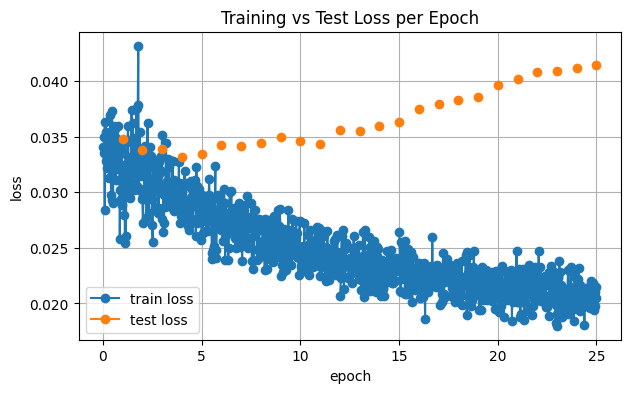

In [39]:
# -------- Plot 1: Loss (train vs test) --------
import matplotlib.pyplot as plt

# 1) Loss: train vs test
plt.figure(figsize=(7,4))
if "loss" in per_epoch and not per_epoch["loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["loss"], marker="o", label="train loss")
if "eval_loss" in per_epoch and not per_epoch["eval_loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["eval_loss"], marker="o", label="test loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training vs Test Loss per Epoch")
plt.grid(True); plt.legend(); plt.show()


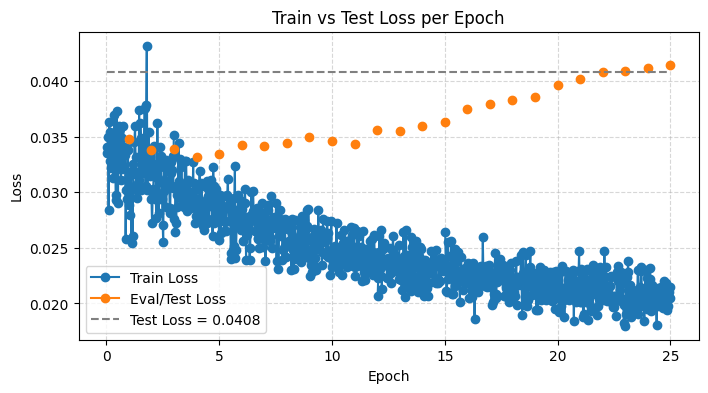

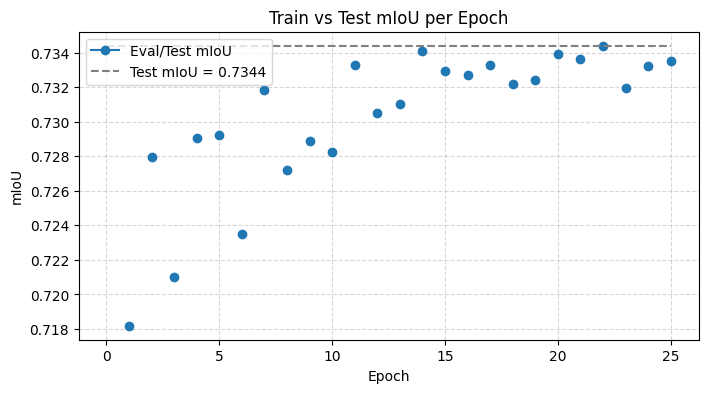

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- ดึง log จาก Trainer ---
logs = getattr(trainer.state, "log_history", [])
df = pd.DataFrame(logs)

# ป้องกันคอลัมน์หาย
for col in ["epoch", "loss", "eval_loss"]:
    if col not in df.columns:
        df[col] = np.nan

# รวมค่าเฉลี่ยต่อ epoch
per_epoch = (
    df.dropna(subset=["epoch"])
      .groupby("epoch", as_index=True)[["loss", "eval_loss"]]
      .last()
      .sort_index()
)

# -------- กราฟที่ 1: Loss (train vs test) --------
plt.figure(figsize=(8, 4))

if "loss" in per_epoch and not per_epoch["loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["loss"], marker="o", label="Train Loss")

if "eval_loss" in per_epoch and not per_epoch["eval_loss"].isna().all():
    plt.plot(per_epoch.index, per_epoch["eval_loss"], marker="o", label="Eval/Test Loss")

# เส้น test loss คงที่จาก test_metrics
t_loss = test_metrics.get("test_loss")
if t_loss is not None and len(per_epoch.index) > 0:
    plt.hlines(
        t_loss,
        xmin=per_epoch.index.min(),
        xmax=per_epoch.index.max(),
        colors="gray",
        linestyles="dashed",
        label=f"Test Loss = {t_loss:.4f}"
    )

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss per Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


# -------- กราฟที่ 2: mIoU (train vs test) --------
plt.figure(figsize=(8, 4))

# หาคอลัมน์ชื่อใดก็ได้ที่มี "iou" ในชื่อ (เผื่อชื่อไม่ตรง)
col_train_iou = next((c for c in df.columns if "train" in c and "iou" in c.lower()), None)
col_eval_iou  = next((c for c in df.columns if "eval"  in c and "iou" in c.lower()), None)

# พล็อต train mIoU
if col_train_iou:
    per_epoch_iou_train = (
        df.dropna(subset=["epoch"])
          .groupby("epoch", as_index=True)[[col_train_iou]]
          .last()
          .sort_index()
    )
    plt.plot(
        per_epoch_iou_train.index,
        per_epoch_iou_train[col_train_iou],
        marker="o",
        label="Train mIoU"
    )

# พล็อต eval/test mIoU (ระหว่างเทรน)
if col_eval_iou:
    per_epoch_iou_eval = (
        df.dropna(subset=["epoch"])
          .groupby("epoch", as_index=True)[[col_eval_iou]]
          .last()
          .sort_index()
    )
    plt.plot(
        per_epoch_iou_eval.index,
        per_epoch_iou_eval[col_eval_iou],
        marker="o",
        label="Eval/Test mIoU"
    )

# เส้น test mIoU คงที่จาก test_metrics
t_miou = next((test_metrics.get(k) for k in [
    "test_mean_iou", "test_mIoU", "test_miou", "test_iou"
] if k in test_metrics), None)

if t_miou is not None and len(per_epoch.index) > 0:
    plt.hlines(
        t_miou,
        xmin=per_epoch.index.min(),
        xmax=per_epoch.index.max(),
        colors="gray",
        linestyles="dashed",
        label=f"Test mIoU = {t_miou:.4f}"
    )

plt.xlabel("Epoch")
plt.ylabel("mIoU")
plt.title("Train vs Test mIoU per Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
